# Fine-Tune BERT LLM for Sentiment Analysis with Kubeflow PyTorchJob

This Notebook will fine-tune Bidirectional Encoder Representations from Transformers (BERT) model with Yelp dataset to analyze text sentiment using distributed training with [Kubeflow PyTorchJob](https://www.kubeflow.org/docs/components/training/overview/).

Pretrained BERT model: https://huggingface.co/google-bert/bert-base-cased

Yelp review full dataset: https://huggingface.co/datasets/yelp_review_full

This Notebook requires:

- At least **3 GPU** on your Kubernetes cluster to fine-tune BERT model on 3 workers.
- AWS S3 bucket to export fine-tuned model.

This example is based on [the HuggingFace fine-tuning tutorial](https://huggingface.co/docs/transformers/en/training).

## Install required packages

We need to install HuggingFace packages to run this Notebook.

In [2]:
!pip install transformers datasets boto3

!pip install git+https://github.com/kubeflow/training-operator.git#subdirectory=sdk/python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kubeflow/training-operator.git to /tmp/pip-req-build-2xncee3j
  Running command git clone --filter=blob:none --quiet https://github.com/kubeflow/training-operator.git /tmp/pip-req-build-2xncee3j
  Resolved https://github.com/kubeflow/training-operator.git to commit b7e0dbc0ee9afd7ed78cd3ade34f08d2b087afef
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Use Train API to Fine-Tune BERT LLM

Kubeflow Training Operator SDK implements a `train` API to effectively fine-tune LLMs on multiple PyTorchJob workers with required configuration. It uses storage initializer to download pre-trained model and dataset, and distribute it across PyTorchJob workers using shared PVCs. After initialization step, pre-created HuggingFace LLM trainer will be executed on each PyTorchJob worker to fine-tune BERT model.

This feature is in **Development Phase**, please provide your feedback by creating [the GitHub issues](https://github.com/kubeflow/training-operator/issues/new) or by using [the Kubeflow Slack channel #kubeflow-training-operator](https://kubeflow.slack.com/archives/C985VJN9F).

To learn more about it check [this proposal](https://github.com/kubeflow/training-operator/blob/master/docs/proposals/train_api_proposal.md).

**TODO (andreyvelich)**: Add docs link when they are ready.

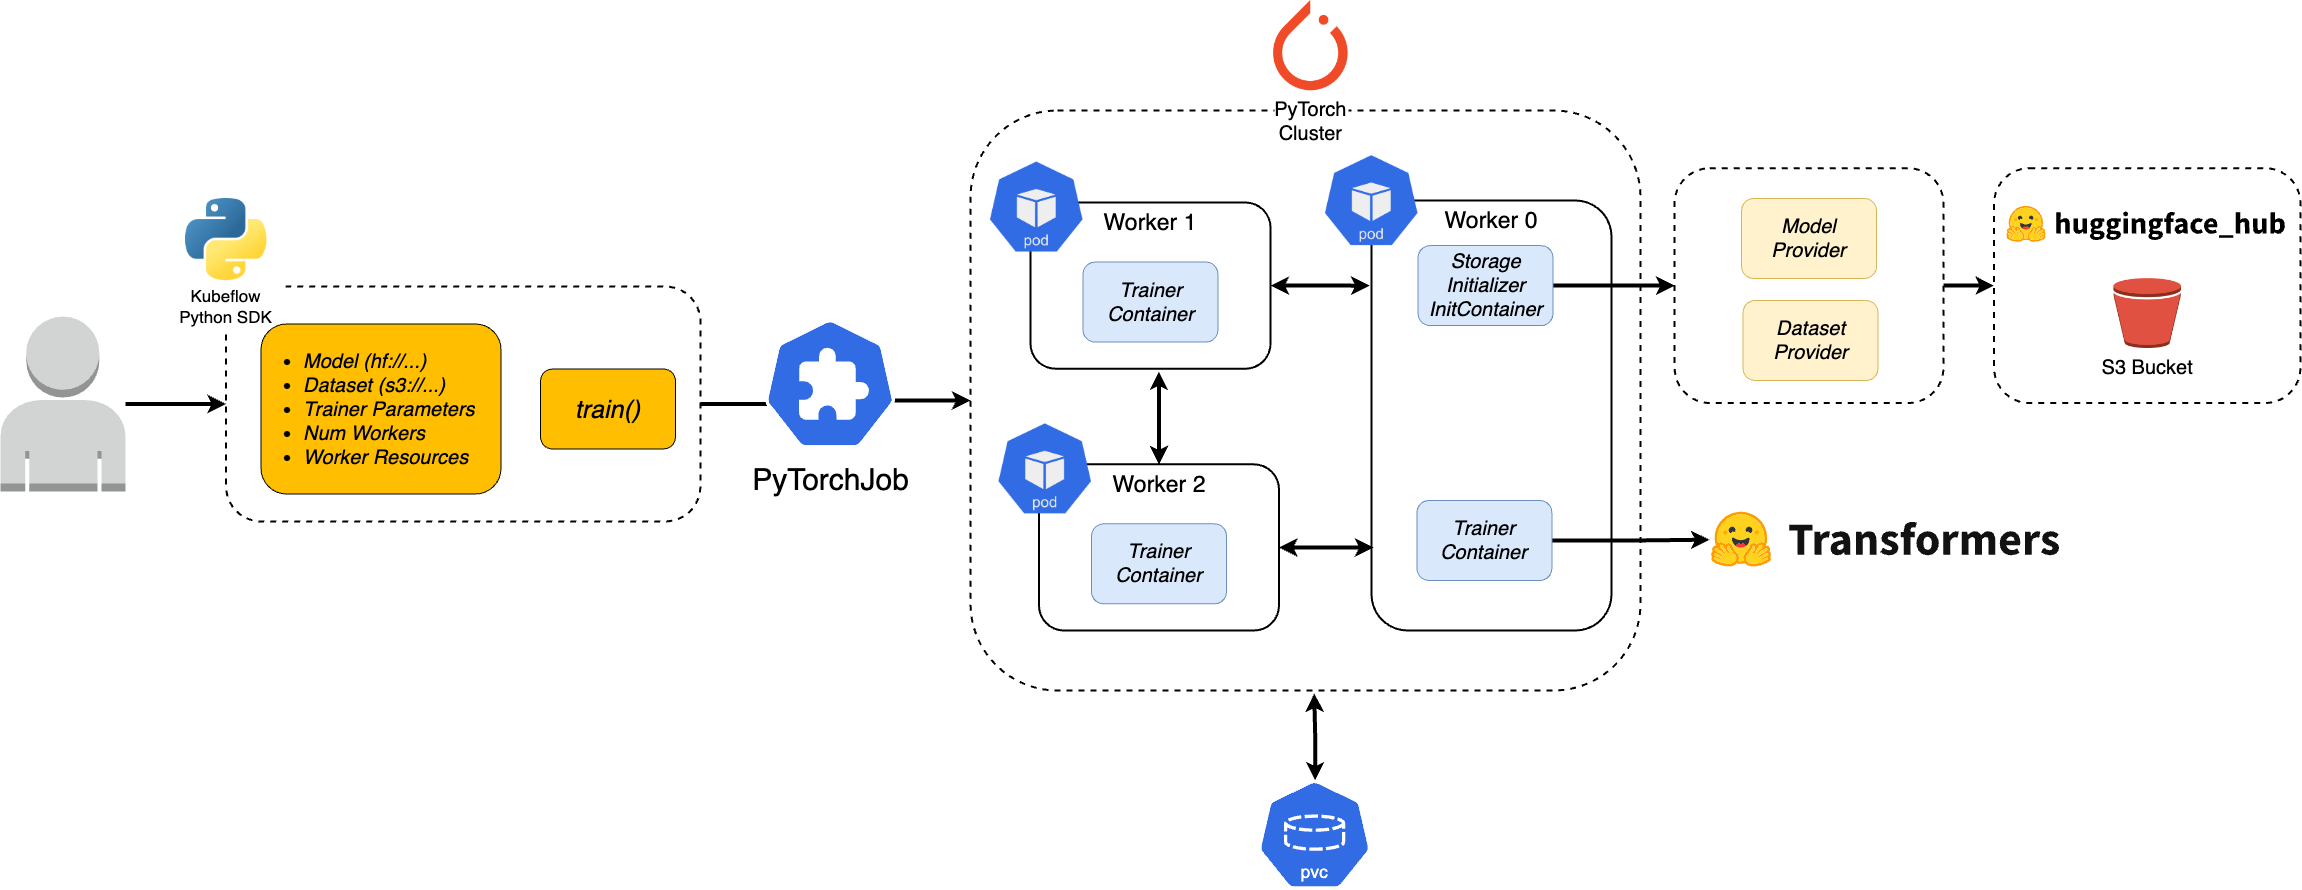


### Install Training Operator SDK to use `train` API

You have to install `kubeflow-training` SDK with the HuggingFace dependencies to use `train` API.


In [ ]:
!pip install "kubeflow-training[huggingface] @ git+https://github.com/kubeflow/training-operator.git#subdirectory=sdk/python"

### Create PyTorchJob using train API

If your Kubernetes environment [supports `ReadOnlyMany` and `ReadWriteOnce` access modes](https://kubernetes.io/docs/concepts/storage/persistent-volumes/#access-modes) for PersistentVolumeClaims (PVCs), you can use more than 1 PyTorchJob worker in `train` API.

In [12]:
from kubeflow.training import TrainingClient
from kubeflow.storage_initializer.hugging_face import (
    HuggingFaceModelParams,
    HuggingFaceTrainParams,
    HfDatasetParams,
)

import transformers
from peft import LoraConfig

job_name_train_api = "fine-tune-bert-train-api"

# Set TOKENIZERS_PARALLELISM = false to avoid warnings from Transformers.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [20]:
# In this example we will use 1 worker and 1 GPU to fine-tune BERT with `train` API.
TrainingClient().train(
    name=job_name_train_api,
    num_workers=1, # nnodes parameter for torchrun command.
    num_procs_per_worker=1, # nproc-per-node parameter for torchrun command.
    # BERT model URI and type of Transformer to train it.
    model_provider_parameters=HuggingFaceModelParams(
        model_uri="hf://google-bert/bert-base-cased",
        transformer_type=transformers.AutoModelForSequenceClassification,
    ),
    storage_config={
        "access_modes": ["ReadWriteOnce"] # Since we use 1 Worker, PVC access mode is ReadWriteOnce.
    },
    # Use 3000 samples from Yelp dataset.
    dataset_provider_parameters=HfDatasetParams(
        repo_id="yelp_review_full",
        split="train[:3000]",
    ),
    # Specify HuggingFace Trainer parameters. In this example, we will skip evaluation and model checkpoints.
    train_parameters=HuggingFaceTrainParams(
        training_parameters=transformers.TrainingArguments(
            output_dir="test_trainer",
            save_strategy="no",
            evaluation_strategy="no",
            do_eval=False,
            disable_tqdm=True,
            log_level="info",
        ),
        # Set LoRA config to reduce number of trainable model parameters.  
        lora_config=LoraConfig(
            r=8,
            lora_alpha=8,
            lora_dropout=0.1,
            bias="none",
        ),
    ),
    resources_per_worker={
        "gpu": 1,
        "cpu": 5,
        "memory": "10G",
    },
)

### Get the PyTorchJob containers

When using `train` API, every PyTorchJob worker (Kubernetes Pod) should have `storage-initialize` initContainer and volume.


In [21]:
pytorchjob = TrainingClient().get_job(job_name_train_api)

print("PyTorchJob Init Containers")
for c in pytorchjob.spec.pytorch_replica_specs["Master"].template.spec.init_containers:
    print(c.name)

print("-" * 40)

print("PyTorchJob Volumes")
for v in pytorchjob.spec.pytorch_replica_specs["Master"].template.spec.volumes:
    print(v.name)

PyTorchJob Init Containers
storage-initializer
----------------------------------------
PyTorchJob Volumes
storage-initializer


### Get the PyTorchJob training logs

Use the same API to get created PyTorchJob logs.

Since we used LoRA config, number of trainable parameters is smaller: **294 912**

In [22]:
logs, _ = TrainingClient().get_job_logs(job_name_train_api, follow=True)


[Pod fine-tune-bert-train-api-master-0]: 2024-03-15T16:45:47Z INFO     Starting HuggingFace LLM Trainer
[Pod fine-tune-bert-train-api-master-0]: /usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1741: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
[Pod fine-tune-bert-train-api-master-0]:   warnings.warn(
[Pod fine-tune-bert-train-api-master-0]: 2024-03-15T16:45:47Z INFO     Setup model and tokenizer
[Pod fine-tune-bert-train-api-master-0]: Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
[Pod fine-tune-bert-train-api-master-0]: You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[Pod fine-tune-bert-train-api-master-0]: 2024-03-15T16:45:48Z INFO     Preprocess dataset
[Pod fine-tune-bert

## Delete the PyTorchJobs

You can delete the created PyTorchJobs.

In [23]:
TrainingClient().delete_job(name=job_name)

In [24]:
TrainingClient().delete_job(name=job_name_train_api)